In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from unidecode import unidecode
import re
import string
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import pipeline
from scipy import stats

In [13]:
caminho_arquivo = 'dataset/SMSSpamCollection'
colunas = ['Tipo', 'Mensagem']

#carregar aquivo para df pandas
df = pd.read_csv(caminho_arquivo, sep='\t', header=None, names=colunas)

df.head()

,Tipo,Mensagem
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
df['Tamanho'] = df['Mensagem'].apply(len)
df['N_Palavras'] = df['Mensagem'].str.split().apply(len)

df.head()

,Tipo,Mensagem,Tamanho,N_Palavras
0,ham,"Go until jurong point, crazy.. Available only ...",111,20
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28
3,ham,U dun say so early hor... U c already then say...,49,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13


# **Analise**

Quantidade de SMS no df: 5572


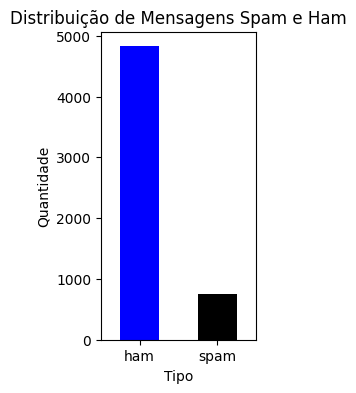

Quantidade de Ham: 4825
Quantidade de Spam: 747


In [15]:
print("Quantidade de SMS no df:", df.shape[0])

contagem_tipo = df['Tipo'].value_counts()

#grafico de barras
plt.figure(figsize=(2,4))
contagem_tipo.plot(kind='bar', color=['blue', 'black'])
plt.title('Distribuição de Mensagens Spam e Ham')
plt.xlabel('Tipo')
plt.ylabel('Quantidade')
plt.xticks(rotation=0)
plt.show()

print("Quantidade de Ham:", contagem_tipo['ham'])
print("Quantidade de Spam:", contagem_tipo['spam'])

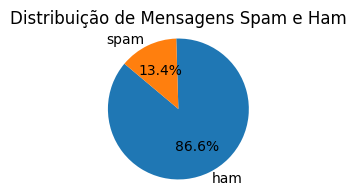

In [16]:
plt.figure(figsize=(2,2))
plt.pie(contagem_tipo, labels=contagem_tipo.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribuição de Mensagens Spam e Ham')
plt.axis('equal')
plt.show()

In [17]:
#separar os df em spam e ham
df_spam = df[df['Tipo'] == 'spam']
df_ham = df[df['Tipo'] == 'ham']

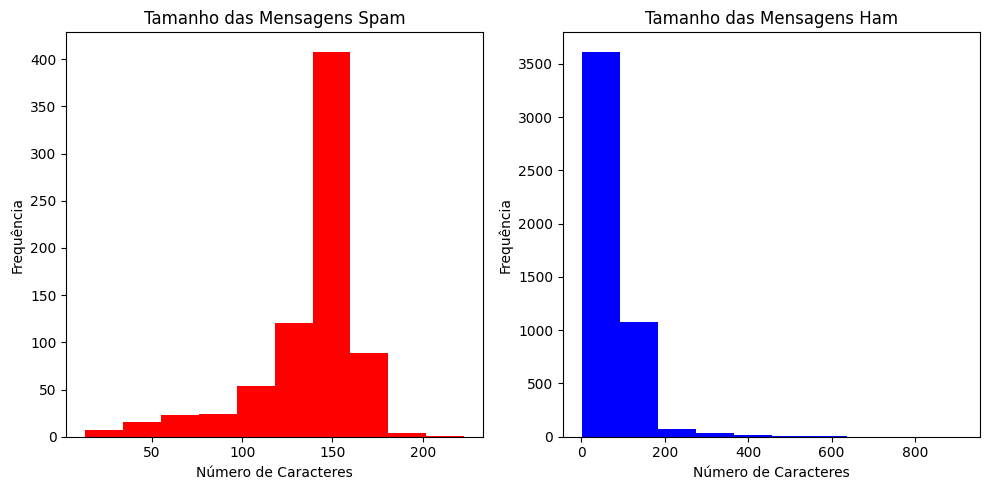

In [18]:
#plot do tamanho das mensagem por tipo
plt.figure(figsize=(10,5))

#hist do tamanho das mensagens spam
plt.subplot(1,2,1)
plt.hist(df_spam['Tamanho'], color='red', alpha=1)
plt.title('Tamanho das Mensagens Spam')
plt.xlabel('Número de Caracteres')
plt.ylabel('Frequência')

#hist do tamanho das mensagens
plt.subplot(1,2,2)
plt.hist(df_ham['Tamanho'], color='blue', alpha=1)
plt.title('Tamanho das Mensagens Ham')
plt.xlabel('Número de Caracteres')
plt.ylabel('Frequência')

plt.tight_layout()
plt.show()


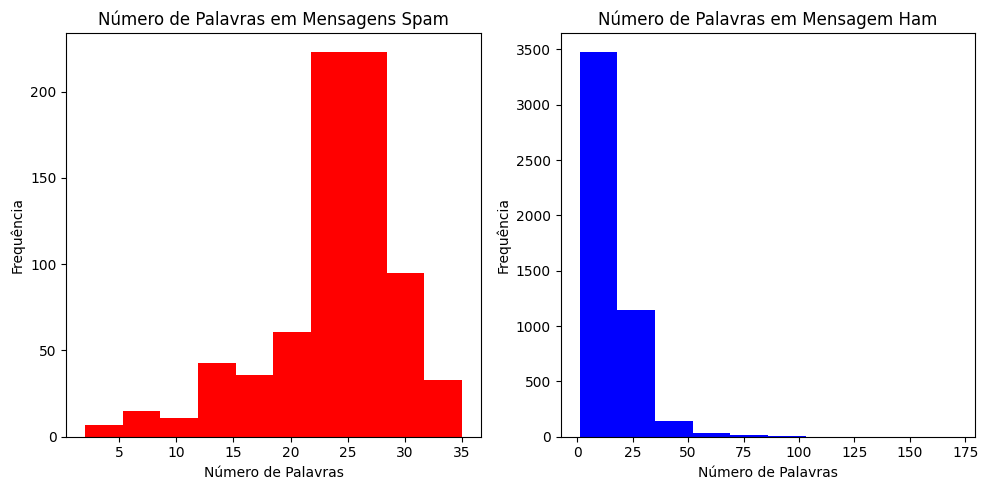

In [19]:
#plot o número de palavras por tipo
plt.figure(figsize=(10,5))

#hist do número de palavras spam
plt.subplot(1,2,1)
plt.hist(df_spam['N_Palavras'], color='red', alpha=1)
plt.title('Número de Palavras em Mensagens Spam')
plt.xlabel('Número de Palavras')
plt.ylabel('Frequência')

#hist do número de palavras ham
plt.subplot(1,2,2)
plt.hist(df_ham['N_Palavras'], color='blue', alpha=1)
plt.title('Número de Palavras em Mensagem Ham')
plt.xlabel('Número de Palavras')
plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

# **Pré-processamento**

## *1 - Normalização, remoção de acentos e stopwords*

In [20]:
#normaliza para minusculo
df['Mensagem'] = df['Mensagem'].str.lower()

#remove acentos
df['Mensagem'] = df['Mensagem'].apply(lambda x: unidecode(x))

#carregar o modelo spaCy para ingles
nlp = spacy.load('en_core_web_sm')

#funcao para remover stopword
def remove_stopword(text):
    doc = nlp(text)
    tokens_sem_stopword = [token.text for token in doc if not token.is_stop] #romove stopwords
    return ' '.join(tokens_sem_stopword) #recria a mensagem sem stopword

df['Mensagem'] = df['Mensagem'].apply(remove_stopword)

df['Tamanho'] = df['Mensagem'].apply(len)
df['N_Palavras'] = df['Mensagem'].str.split().apply(len)
df.head()

,Tipo,Mensagem,Tamanho,N_Palavras
0,ham,"jurong point , crazy .. available bugis n grea...",92,19
1,ham,ok lar ... joking wif u oni ...,31,8
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,134,23
3,ham,u dun early hor ... u c ...,27,8
4,ham,"nah think goes usf , lives",26,6


## *2 - Remove marcações e referencias de usuário*

In [21]:
#funcao para remover hashtags e referencias de usuario
def remove_tags_user(text):
    texto_sem_tag_user = re.sub(r'@[^\s]+|#[^\s]+', '', text) #[^\s]+ procura mais caracteres que n é o espaço
    return texto_sem_tag_user

#aplica a funcao na coluna mensagem
df['Mensagem'] = df['Mensagem'].apply(remove_tags_user)

df['Tamanho'] = df['Mensagem'].apply(len)
df['N_Palavras'] = df['Mensagem'].str.split().apply(len)
df.head()

,Tipo,Mensagem,Tamanho,N_Palavras
0,ham,"jurong point , crazy .. available bugis n grea...",92,19
1,ham,ok lar ... joking wif u oni ...,31,8
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,134,23
3,ham,u dun early hor ... u c ...,27,8
4,ham,"nah think goes usf , lives",26,6


## *3 - Reduz possiveis repetições*

In [22]:
#funcao para reduzir repeticoes
def reduz_repeticao(text):
    return re.sub(r'(.)\1+', r'\1\1', text)#(.)\1+ procura por qualquer caractere seguido pelo menos uma repetição, r'\1\1 substiu essa sequencia por duas ocorrencias do caractere

df['Mensagem'] = df['Mensagem'].apply(reduz_repeticao)

df['Tamanho'] = df['Mensagem'].apply(len)
df['N_Palavras'] = df['Mensagem'].str.split().apply(len)
df.head()

,Tipo,Mensagem,Tamanho,N_Palavras
0,ham,"jurong point , crazy .. available bugis n grea...",90,19
1,ham,ok lar .. joking wif u oni ..,29,8
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,134,23
3,ham,u dun early hor .. u c ..,25,8
4,ham,"nah think goes usf , lives",26,6


## *4 - Remove urls com formato www https*

In [23]:
#funcao para remover urls
def remove_urls(text):
    return re.sub(r'\b(?:https?://|www\.)\S+\b', '', text) #substitui qualquer sequencia que começa com https:// ou www. até achar um caractere em branco

df['Mensagem'] = df['Mensagem'].apply(remove_urls)

df['Tamanho'] = df['Mensagem'].apply(len)
df['N_Palavras'] = df['Mensagem'].str.split().apply(len)
df.head()

,Tipo,Mensagem,Tamanho,N_Palavras
0,ham,"jurong point , crazy .. available bugis n grea...",90,19
1,ham,ok lar .. joking wif u oni ..,29,8
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,134,23
3,ham,u dun early hor .. u c ..,25,8
4,ham,"nah think goes usf , lives",26,6


## *5 - Remove pontuações*

In [24]:
#Funcao parar remover pontuacao
def remove_pontuacao(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

df['Mensagem'] = df['Mensagem'].apply(remove_pontuacao)

df['Tamanho'] = df['Mensagem'].apply(len)
df['N_Palavras'] = df['Mensagem'].str.split().apply(len)
df.head()

,Tipo,Mensagem,Tamanho,N_Palavras
0,ham,jurong point crazy available bugis n great w...,83,15
1,ham,ok lar joking wif u oni,25,6
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,130,22
3,ham,u dun early hor u c,21,6
4,ham,nah think goes usf lives,25,5


## *6 - Remover entidades referentes a localização e organização utilizando spaCy*

In [25]:
#funcao para remover entidadesde localizacao e organizacao
def remove_loc_org(text):
    doc = nlp(text)
    texto_limpo = ' '.join([token.text if token.ent_type_ not in ['LOC', 'ORG'] else '' for token in doc])#se a entidade tokne.ent_type_ n for de LOC(localizacao) ou ORG(organizacao) o texto do token é mantido, se n vira uma string vazia
    return texto_limpo.strip()

df['Mensagem'] = df['Mensagem'].apply(remove_loc_org)

df['Tamanho'] = df['Mensagem'].apply(len)
df['N_Palavras'] = df['Mensagem'].str.split().apply(len)
df.head()

,Tipo,Mensagem,Tamanho,N_Palavras
0,ham,jurong point crazy available bugis n great...,85,15
1,ham,ok lar joking wif u oni,25,6
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,131,22
3,ham,u dun early hor u c,21,6
4,ham,nah think goes usf lives,26,5


## *7 - Remover tokens numericos*

In [26]:
#funcao para remover tokens numericos
def remove_tokens_num(text):
    return re.sub(r'\b\w*\d\w*\b', '', text)#\b fronteira de palavra, \w* zero ou mais caracteres de palavra, \d qualquer digito, removendo palavra que contenham número 

df['Mensagem'] = df['Mensagem'].apply(remove_tokens_num)

df['Tamanho'] = df['Mensagem'].apply(len)
df['N_Palavras'] = df['Mensagem'].str.split().apply(len)
df.head()


,Tipo,Mensagem,Tamanho,N_Palavras
0,ham,jurong point crazy available bugis n great...,85,15
1,ham,ok lar joking wif u oni,25,6
2,spam,free entry wkly comp win fa cup final tkts ...,100,17
3,ham,u dun early hor u c,21,6
4,ham,nah think goes usf lives,26,5


## *8 - Remover palavras com menos de 3 caracteres*

In [27]:
#funcao para remover palavras com menos de 3 caracteres
def remove_palavras_pequenas(text):
    return re.sub(r'\b\w{1,2}\b', '', text)#\w{1,2} encontra palavras que tem de 1 a 2 caracteres

df['Mensagem'] = df['Mensagem'].apply(remove_palavras_pequenas)

df['Tamanho'] = df['Mensagem'].apply(len)
df['N_Palavras'] = df['Mensagem'].str.split().apply(len)
df.head()


,Tipo,Mensagem,Tamanho,N_Palavras
0,ham,jurong point crazy available bugis great ...,81,12
1,ham,lar joking wif oni,22,4
2,spam,free entry wkly comp win cup final tkts ...,96,15
3,ham,dun early hor,18,3
4,ham,nah think goes usf lives,26,5


## *9 - Remover nomes pessoais*

<!--#funcao para calcular o Tf (Term Frequency)
def calcula_tf(text):
    palavras = text.split() #separa o texto em palavras
    count_palavras = Counter(palavras) #conta a frequencia das palavras
    total_palavras = len(palavras) 
    tf = {palavras: count_palavras[palavras] / total_palavras for palavras in count_palavras} #razao entre o numero de vezes que a palavra aparece e o numero total de palavras no documento
    return tf

#funcao para calcular o idf (Inverse Document Frequency)
def calcula_idf(data):
    total_documentos = len(data)
    idf = {}
    todas_palavras = ' '.join(data).split() #junta os documentos em uma string e divide a string em uma lista de todas as palavras
    palavras_unicas = set(todas_palavras) #cria um conjunto de palavras unicas

    for palavra in palavras_unicas:
        count_palavra = sum(1 for doc in data if palavra in doc.split()) #para cada palavras unica, percorre todos os doc e verifica se a palavra esta presente nele, se estiver incrementa o contados
        idf[palavra] = math.log(total_documentos / (1 + count_palavra)) #calcula o IDF da palavra atual usando IDF = log(N / (1+n)), N numero de documento, n numero de documento que tem a palavra
    
    return idf -->

<!--#calcula o TF para cada documento
df['TF'] = df['Mensagem'].apply(calcula_tf)

#calcula o IDF para o conjunto de documentos
idf_values = calcula_idf(df['Mensagem'])

#cria um conjunto de todas as palavras únicas nos documentos
words_set = set().union(*[doc.keys() for doc in df['TF']])

#calcula diretamente os valores TF-IDF na matriz
tfidf_matrix = []
for i, row in df.iterrows():
    tfidf_matrix.append([row['TF'][word] * idf_values[word] if word in row['TF'] else 0 for word in words_set])
    -->


# **Treinamento**

In [38]:
def bert_zero_shot(texts, labels, classifier):

    predictions = []

    for text in texts:
        result = classifier(text, labels)
        predictions.append(result['labels'][0])

    return predictions

def metricas_modelo(y_pred, y_test):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1_score_macro = f1_score(y_test, y_pred, average='macro')

    return accuracy, precision, recall, f1_score_macro



In [44]:
classifier = pipeline("zero-shot-classification")

mensagens = df['Mensagem'].tolist()
rotulos = df['Tipo'].apply(lambda x: ['spam','ham']).tolist()

pred_bert = bert_zero_shot(mensagens, rotulos, classifier)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [43]:
print(df['Mensagem'].tolist())
print(rotulos)

['jurong point   crazy   available bugis  great world   buffet   cine got amore wat', ' lar   joking wif  oni', 'free entry  wkly comp win  cup final tkts     text   receive entry questionstd txt ratetc apply ', ' dun early hor    ', 'nah think goes usf   lives', 'freemsg hey darling  week word   like fun        std chgs send    rcv', 'brother like speak   treat like aids patent', 'request   melle melle   oru minnaminunginte nurungu vettam    set callertune callers   press    copy friends callertune', 'winner    valued network customer selected receivea  prize reward   claim    claim code    valid  hours', 'mobile  months     entitled update latest colour mobiles camera free   mobile update  free ', 'gon  home soon want talk stuff anymore tonight      cried today', 'chances win cash     pounds txt    send    cost    day         tsandcs apply reply  ', ' week free membership  prize jackpot   txt word   claim     wwdbuknet lccltd pobox ', 'searching right words thank breather   promise  